In [52]:
import mitsuba as mi
import cv2
mi.set_variant("cuda_ad_rgb")
import imageio
import random 
from mitsuba import ScalarTransform4f as T
import math
import numpy as np
import json 
import os 
import itertools
import argparse  # Import argparse library
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

config = {
    'obj_path': '/data2/datasets/ruoguli/idl_project_datas/blobs/obj',
    'obj_scales': [13, 200, 14, 17, 150, 200, 200, 170,17, 180],
    'bsdf_path': '/data2/datasets/ruoguli/idl_project_datas/bsdf',
    'lights_per_sample' : 32, 
    'num_angles' : 7, 
    'bsdfs_per_view' : 1, 
    'save_root' : '/data2/datasets/ruoguli/idl_project_datas/generated_dataset'
        
}

class Camera: 
    def __init__(self, intrinsic_matrix, rvec,tvec,resolution_x = 1920, resolution_y = 1200): 
        
        self.camera_matrix = intrinsic_matrix
        self.rvec = rvec
        self.tvec = tvec
        self.resolution_x = resolution_x
        self.resolution_y = resolution_y
        
        self.fx = self.camera_matrix[0][0] 
        self.fy = self.camera_matrix[1][1]
        self.cx = self.camera_matrix[0][2]
        self.cy = self.camera_matrix[1][2]
        self.focal_length_mm = ((self.fx+self.fy)/2 * 36.0) /resolution_x
        

    def get_extrinsic (self):
        """
        Get extrinsic transformation in mitsuba format
        return: ScalarTransform4f
        """
        # tvec = self.tvec
        # camera_matrix = self.camera_matrix
        # fx = camera_matrix[0][0]
        # fy = camera_matrix[1][1]
        # cx = camera_matrix[0][2]
        # cy = camera_matrix[1][2]
        # rvec = self.rvec
        # R, _ = cv2.Rodrigues(rvec)
    
        # # Compute the inverse rotation matrix
        # R_inv = R.T
    
        # # Compute the inverse translation vector
        # t_inv = -R_inv @ tvec
    
        # # Display the camera position in world coordinates
        # cam_pos = t_inv.flatten().tolist()

        # mat = [ #Convert to mitsuba coordinate system, which differs from both blender and opencv. 
        #         [-R_inv[0,0], -R_inv[0,1], R_inv[0,2], cam_pos[0]],
        #         [-R_inv[1,0], -R_inv[1,1], R_inv[1,2], cam_pos[1]], 
        #         [-R_inv[2,0], -R_inv[2,1], R_inv[2,2], cam_pos[2]],
        #         [0,0,0,1]
        #       ] 
        # return T(mat)
        return T().look_at(origin = [0., 0., 1000.], target = [0.,0.,0.], up = [0., 1., 0.])
    def get_target_origin (self):
        """
        intersection with z-plane
        """
        extrinsic_matrix  = np.array(self.get_extrinsic().matrix)
        cam_pos  = [extrinsic_matrix[0][3], extrinsic_matrix[1][3], extrinsic_matrix[2][3]]
        # print(cam_pos)
        t = cam_pos[2] / extrinsic_matrix[2,2]
        return [cam_pos[0] - t* extrinsic_matrix[0][2], cam_pos[1] - t* extrinsic_matrix[1][2], cam_pos[2] - t* extrinsic_matrix[2][2]]
    


def load_sensor(camera: Camera, gt = False):
    """
    camera: Camera
    """
    
#     sensor_width = 6.624 
#     sensor_height =  4.14
    resolution_x = camera.resolution_x #Constant for both 3 cameras
    resolution_y = camera.resolution_y
    # Display the camera position in world coordinates
    rvec = camera.rvec
    angle = np.linalg.norm(rvec) * 180 / math.pi 
    axis = rvec / np.linalg.norm(rvec)
    # focal_length_mm = focal_length_mm_bld * 36.0 / sensor_width
    # print(focal_length_mm)
    if gt: 
        return mi.load_dict({
            'type' : 'perspective',
            'focal_length' : str(camera.focal_length_mm) + "mm",
            'principal_point_offset_x' : -(camera.cx - resolution_x / 2.0) / resolution_x,
            'principal_point_offset_y' : -(camera.cy - resolution_y / 2.0) / resolution_y,
    
            # 'to_world' : T.look_at(origin = cam_pos, target = [0,0,0], up = [0,1,0]), #need change
            'to_world' : camera.get_extrinsic(),
            
            'sampler': {
                'type': 'stratified',
                'sample_count': 1, #param
                'jitter' : False
            },
            
            'film': {
                'type': 'hdrfilm',
                'width': resolution_x,
                'height': resolution_y,
                'pixel_format': 'rgb',
                'filter': {'type': 'box'}
            }
    })
        
    return mi.load_dict({
        'type' : 'perspective',
        'focal_length' : str(camera.focal_length_mm) + "mm",
        'principal_point_offset_x' : -(camera.cx - resolution_x / 2.0) / resolution_x,
        'principal_point_offset_y' : -(camera.cy - resolution_y / 2.0) / resolution_y,

        # 'to_world' : T.look_at(origin = cam_pos, target = [0,0,0], up = [0,1,0]), #need change
        'to_world' : camera.get_extrinsic(),
        
        'sampler': {
            'type': 'stratified',
            'sample_count': 256 #param
        },
        
        'film': {
            'type': 'hdrfilm',
            'width': resolution_x,
            'height': resolution_y,
            'pixel_format': 'rgb',
        },
    })

def load_mesh(filename, bsdf, matrix_world = T()):
    """
    filename: String
    matrix_world: ScalarTransform4f
    bsdf: dict or mi.load_dict
    """
    # print(filename, matrix_world, bsdf)
    return mi.load_dict({
        'type' : 'obj', 
        'filename' : filename, 
        'to_world' : matrix_world,
        'bsdf' : bsdf
    })

def load_light(light_pos, obj_pos = [0,0,0]): 
    return mi.load_dict({
        'type' : 'rectangle',
        # 'flip_normals' : True,
        'to_world' : T().look_at(origin = light_pos, target = obj_pos, up = [0,1,0]).scale(24.5),
        'emitter' : {
            'type' : 'area', 
            'radiance': {
                'type': 'rgb',
                'value': 150, #Change light intensity there
            }
        }
    })
    

def render(filename, obj_matrix, light_pos, camera, bsdf, gen_gt = True): 
    """
    
    gen_gt (bool) : Whether to generate ground-truth. 
    return: image, geometric normal, shading normal, depth map. 
    """
    # print(filename)
    np_obj_matrix = np.array(obj_matrix.matrix)
    obj_pos = [np_obj_matrix[0][3], np_obj_matrix[1][3], np_obj_matrix[2][3]]
    # obj_pos = [200000,200000,0]
    # print(obj_pos)
    sensor = load_sensor(camera)
    if gen_gt: 
        gt_sensor = load_sensor(camera, gt = True)
    obj = load_mesh(filename = filename, bsdf = bsdf, matrix_world = obj_matrix)
    light = load_light(light_pos, obj_pos) 
    if gen_gt:
        gt_scene = mi.load_dict({
            'type' : 'scene' ,
            'integrator': {
                'type' : 'aov',
                'aovs' : 'gn:geo_normal',
            },
            'obj' : obj,
            'light' : light,
            'constant_emitter' : {
                'type': 'constant',
                'radiance': {
                    'type': 'rgb',
                    'value': 0.005,
                }
            }
        }) 

    scene = mi.load_dict({
        'type' : 'scene' ,
        'integrator': {
            'type' : 'path',
            'max_depth' : -1
        },
        'obj' : obj,
        'light' : light,
        'constant_emitter' : {
            'type': 'constant',
            'radiance': {
                'type': 'rgb',
                'value': 0.005,
            }
        }
    })

    # print(mi.traverse(scene))
    image =  mi.render(scene, spp=256, sensor=sensor) #spp param
    if gen_gt: 
        normal = mi.render(gt_scene, spp = 1, sensor = gt_sensor)
    # return res
    if gen_gt:
        return image, normal
    else:
        return image 

def blobby_dataset_generation(): 
    num_angles = config['num_angles']
    image_save_root = os.path.join(config['save_root'], 'image')
    normal_save_root = os.path.join(config['save_root'], 'normal') 
    if not os.path.exists(image_save_root):
    # Create the directory if it doesn't exist
        os.makedirs(image_save_root)
    if not os.path.exists(normal_save_root): 
        os.makedirs(normal_save_root)
    
    x_axis = [1,0,0]
    y_axis = [0,1,0]
    info_of_out = dict()
    scales = config['obj_scales'] 
    angle = 360.0 / num_angles 
    obj_names = sorted(
    [name for name in os.listdir(config['obj_path']) if not name.startswith('.')])
    bsdf_names = sorted(
    [name for name in os.listdir(config['bsdf_path']) if not name.startswith('.')])
    sample_id = 0 
    for obj_id in range(len(obj_names)):
        for i in range (num_angles): 
            for j in range (num_angles):
                sample_id += 1 
                matrix_world = T().rotate(x_axis, angle * i).rotate(y_axis, angle*j).scale(scales[obj_id])
                bsdf_name = bsdf_names[random.randint(0, len(bsdf_names)-1)]
                bsdf = mi.load_dict({
                    'type': 'measured',
                    'filename' : os.path.join(config['bsdf_path'], bsdf_name) # Use a random bsdf 
                 })
                light_positions = [random_light_position(800.0) for i in range(config['lights_per_sample'])] 
                gen_gt = True 
                light_id = 0
                for light in light_positions: 
                    light_id += 1 
                    base_name = f"{sample_id}_{light_id}"
                    image_save_path = os.path.join(image_save_root, f"{base_name}.png")
                    if gen_gt == True: 
                        gen_gt = False
                        print(obj_names[obj_id])
                        image, geo_normal= render(filename = os.path.join(config['obj_path'], obj_names[obj_id]), 
                                                                     obj_matrix = matrix_world, 
                                                                     light_pos = light,
                                                                     camera = camera_40339971, 
                                                                     bsdf = bsdf, 
                                                                     gen_gt = True
                                                                    )
                        normal_save_path = os.path.join(normal_save_root, f"{base_name}.exr")
                        mi.util.write_bitmap(image_save_path, image)
                        mi.util.write_bitmap(normal_save_path, geo_normal) 
                        
                    else:
                        image = render(filename = os.path.join(config['obj_path'], obj_names[obj_id]), 
                                                                     obj_matrix = matrix_world, 
                                                                     light_pos = light,
                                                                     camera = camera_40339971, 
                                                                     bsdf = bsdf, 
                                                                     gen_gt = False
                                                                )
                        mi.util.write_bitmap(image_save_path, image)
                        
                    info_of_out[base_name] = {
                        'obj_name': obj_names[obj_id],
                        'bsdf_name': bsdf_name, 
                        'light_position': light,
                        'x_rot' : i* angle,
                        'y_rot' : j*angle
                    }
    
    with open(os.path.join(config['save_root'], 'info_dataset.json'), 'w') as f:
        json.dump(info_of_out, f)
         
                
    
    


def blobs_generate(num_angles = 7):
    x_axis = [1,0,0]
    y_axis = [0,1,0]
    num_light = 8
    light_positions = [
        [481.0, -383.0, 527.0],  # Top left bottom
        [481.0, -338.0, 885.0],  # Top left up
        [-552.0, -300.0, 480.0],  # Top right bottom
        [-532.0, -300.0, 890.0],  # Top right up
        [475.0, 198.0, 460.0],  # Left mid bottom
        [283.0, 168.0, 1010.0],  # Top left mid
        [-365.0, 103.0, 1010.0],  # Top right mid
        [-518.0, 162.0, 460.0]  # Right mid bottom
    ]
    scales = [10, 170, 11, 13, 120, 160, 160, 140,14, 150]
    angle = 360.0 / num_angles 
    for obj_id in range (1, 11): 
        obj_name = f"blob{str(obj_id).zfill(2)}"
        # print(obj_name)
        for i in range (num_angles): 
            for j in range (num_angles):
                for k in range(num_light):
                    matrix_world = T().rotate(x_axis, angle * i).rotate(y_axis, angle*j).scale(scales[obj_id-1])
                    image, geo_normal, sh_normal, depth = render(filename = f"blobs/{obj_name}.obj", obj_matrix = matrix_world, light_pos = light_positions[k])
                    base_name = f"{obj_name}x{i*30}y{j*30}l{k}"
                    mi.util.write_bitmap(f"photostereo_data2/{base_name}_img.png", image)
                    np.save(f"photostereo_data2/{base_name}_gn.npy" ,geo_normal)
                    np.save(f"photostereo_data2/{base_name}_sn.npy" ,sh_normal)
                    np.save(f"photostereo_data2/{base_name}_dp.npy" ,depth)

def random_light_position(r: float): 
    """
    r: float, the radius of the hemisphere
    """
    # Generate a random azimuthal angle theta in [0, 2*pi]
    theta = np.random.uniform(0, 2 * np.pi)
    
    z = float(np.random.uniform(0, r))
    
    # Compute the corresponding radius in the xy-plane
    xy_radius = np.sqrt(r**2 - z**2)
    
    # Compute x and y coordinates
    x = float(xy_radius * np.cos(theta))
    y = float(xy_radius * np.sin(theta))
    
    
    return (x, y, z)

def data_generate(camera, obj_pos = [0.0, 0.0, 0.0], start_id=0, end_id=170):
    
    data_basepath = "/samsung_ssd/leo1432/anaconda/data_obj"
    res_basepath = "/samsung_ssd/leo1432/anaconda/generated_data"
    if not os.path.exists(data_basepath): 
        os.makedirs(res_basepath)
    img_path = f"{res_basepath}/img"
    gt_path = f"{res_basepath}/GT"
    if not os.path.exists(img_path): 
        os.makedirs(img_path)
    if not os.path.exists(gt_path): 
        os.makedirs(gt_path)
    gn_path = f"{gt_path}/geo_normal"
    sn_path = f"{gt_path}/shading_normal"
    dp_path = f"{gt_path}/depth"
    if not os.path.exists(gn_path): 
        os.makedirs(gn_path)
    if not os.path.exists(sn_path): 
        os.makedirs(sn_path)
    if not os.path.exists(dp_path): 
        os.makedirs(dp_path)
    num_datas = [20, 50, 100]
    x_axis = [1,0,0]
    y_axis = [0,1,0]
    light_positions = [
        [481.0, -383.0, 527.0],  # Top left bottom
        [481.0, -338.0, 885.0],  # Top left up
        [-552.0, -300.0, 480.0],  # Top right bottom
        [-532.0, -300.0, 890.0],  # Top right up
        [475.0, 198.0, 460.0],  # Left mid bottom
        [283.0, 168.0, 1010.0],  # Top left mid
        [-365.0, 103.0, 1010.0],  # Top right mid
        [-518.0, 162.0, 460.0]  # Right mid bottom
    ]
    for folder_id in range (3):
        data_path = f"{data_basepath}/{str(folder_id+1).zfill(2)}"
        for obj_id in range(num_datas[folder_id]):
            final_obj_id = obj_id + sum(num_datas[:folder_id])
            if(final_obj_id<start_id or final_obj_id >= end_id): continue
            obj_path = f"{data_path}/{str(obj_id).zfill(3)}.obj"
            # print(obj_path)
            for config_id, (x_rot, y_rot) in enumerate(itertools.product([-10, 0, 10], repeat=2)):
                matrix_world = T.translate(obj_pos).rotate(x_axis, x_rot).rotate(y_axis,y_rot)
                img_folder_path = f"{img_path}/{final_obj_id}-{config_id}"
                if not os.path.exists(img_folder_path): 
                    os.makedirs(img_folder_path)
                
                for light_id in range(8):
                    generated_img_path = f"{img_folder_path}/{light_id}.png"
                    if(light_id == 0):
                        image, geo_normal, sh_normal, depth = render(filename = obj_path, obj_matrix = matrix_world, light_pos = light_positions[light_id],camera = camera, gen_gt = True)
                        generated_gn_path = f"{gn_path}/{final_obj_id}-{config_id}.exr"
                        generated_sn_path = f"{sn_path}/{final_obj_id}-{config_id}.exr"
                        generated_dp_path = f"{dp_path}/{final_obj_id}-{config_id}.exr"
                        mi.util.write_bitmap(generated_gn_path, geo_normal)
                        mi.util.write_bitmap(generated_sn_path, sh_normal)
                        mi.util.write_bitmap(generated_dp_path, depth)
                        # np.save(generated_gn_path, geo_normal)
                        # np.save(generated_sn_path, sh_normal)
                        # np.save(generated_dp_path, depth)
                        mi.util.write_bitmap(generated_img_path, image)

                    else:
                        image = render(filename = obj_path, obj_matrix = matrix_world, light_pos = light_positions[light_id],camera = camera, gen_gt = False)
                        mi.util.write_bitmap(generated_img_path, image)
                    print(generated_img_path)


def data_generate_demo(num_angles = 7):
    x_axis = [1,0,0]
    y_axis = [0,1,0]
    num_light = 8
    light_positions = [
        [481.0, -383.0, 527.0],  # Top left bottom
        [481.0, -338.0, 885.0],  # Top left up
        [-552.0, -300.0, 480.0],  # Top right bottom
        [-532.0, -300.0, 890.0],  # Top right up
        [475.0, 198.0, 460.0],  # Left mid bottom
        [283.0, 168.0, 1010.0],  # Top left mid
        [-365.0, 103.0, 1010.0],  # Top right mid
        [-518.0, 162.0, 460.0]  # Right mid bottom
    ]
    scales = [10, 170, 11, 13, 120, 160, 160, 140,14, 150]
    angle = 360.0 / num_angles 
    obj_name = "03.obj"
    # print(obj_name)
    for i in range (num_angles): 
        for j in range (num_angles):
            for k in range(num_light):
                matrix_world = T().rotate(x_axis, angle * i).rotate(y_axis, angle*j).scale(10)
                image, geo_normal, sh_normal, depth = render(filename = obj_name, obj_matrix = matrix_world, light_pos = light_positions[k])
                base_name = f"03testx{i*30}y{j*30}l{k}"
                mi.util.write_bitmap(f"{base_name}_img.png", image)
                # np.save(f"{base_name}_gn.npy" ,geo_normal)
                # np.save(f"{base_name}_sn.npy" ,sh_normal)
                # np.save(f"{base_name}_dp.npy" ,depth)
                print(base_name, "generated")



rvec_40314439 = np.array([-1.87917633, -1.85177356, -0.62154305])
tvec_40314439 = np.array( [  32.76152518, -40.87853469, 1251.29704418])
intrinsic_40314439 = np.array([
        [2511.0299699769816, 0.0, 920.0602102001872],
        [0.0, 2499.913364632983, 670.2196363010752],
        [0.0, 0.0, 1.0]
    ])
camera_40314439 = Camera(intrinsic_40314439, rvec_40314439, tvec_40314439)

rvec_40339974 =  np.array( [-0.01959622, 2.98679198, 0.63568044]) #Only need to change here for recalibration of intrinsic and extrinsic matrix
tvec_40339974 = np.array([  30.99377083, -12.33525547, 1042.78537089])
cam_pos_40339974 = [123.19849787, -410.99361859, 951.01024059]
intrinsic_40339974 = np.array([
    [2356.6818810201453, 0.0, 901.3215694406316],
    [0.0, 2342.597409138087, 625.8611983400893],
    [0.0, 0.0, 1.0]
])
camera_40339974 = Camera(intrinsic_40339974, rvec_40339974, tvec_40339974)

rvec_40339971 = np.array( [-1.90149009, 1.89895251, 0.67595728])
tvec_40339971 = np.array( [  86.68463089, -60.60396495, 1232.63088321])
intrinsic_40339971 = np.array([
    [2858.398214864097, 0.0, 762.4775970719693],
    [0.0, 2841.6177398488835, 707.8462431098854],
    [0.0, 0.0, 1.0]
])
# intrinsic_40339971 = np.array([
#     [2858.398214864097, 0.0, 960.0],
#     [0.0, 2841.6177398488835, 600.0],
#     [0.0, 0.0, 1.0]
# ])
camera_40339971 = Camera(intrinsic_40339971, rvec_40339971, tvec_40339971)
# rvec =  np.array( [-0.01959622, 2.98679198, 0.63568044])
# tvec = np.array([  30.99377083, -12.33525547, 1042.78537089])
# cam_mat = np.array()
# cam_pos = [123.19849787, -410.99361859, 951.01024059]
# angle = np.linalg.norm(rvec) * 180 / math.pi 
# axis = rvec / np.linalg.norm(rvec)


# print(T.translate(tvec.tolist()).rotate(axis = axis, angle = angle))
# print(T.look_at(origin = cam_pos, target = [210.12,14.49, 0.0], up = [0,1,0] ))


In [59]:
info_of_out = dict()
info_of_out["1"] = {"2": 3}
with open(os.path.join(config['save_root'], 'info_dataset.json'), 'w') as f:
        json.dump(info_of_out, f)

In [53]:
arr = np.load("generated_data/GT/depth/0-2.npy")
mi.util.write_bitmap('float_img.jpeg', arr)
np.savez_compressed('float_img.npz', arr)


help(mi.util.write_bitmap)

Help on function write_bitmap in module mitsuba.python.util:

write_bitmap(filename, data, write_async=True, quality=-1)
    Write the RGB image in `data` to a PNG/EXR/.. file.



In [18]:
mi.Point3f(0,0,0)

[[0, 0, 0]]

In [ ]:
# # image = cv2.imread('float_img.jpeg')

# # # Convert the image from BGR to RGB (OpenCV loads images in BGR format)
# # image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # print(image_rgb.max())

# import h5py

# with h5py.File('array.h5', 'w') as f:
#     f.create_dataset('array', data=arr, compression='gzip')
# arr16 = arr.astype(np.float16)
# print(arr[624][678], arr16[624][548])
import scipy.io
scipy.io.savemat('array.mat', {'array': arr})

# bmp = mi.Bitmap("float_img.exr")
# read_np = np.array(bmp)
# print(read_np.mean(), arr.mean())

In [5]:
import drjit as dr

# Check if CUDA backend is available
if dr.has_backend(dr.JitBackend.CUDA):
    num_devices = dr.device_count()
    print(f"Number of CUDA devices available: {num_devices}")
else:
    print("CUDA is not available")

AttributeError: module 'drjit' has no attribute 'device_count'

In [19]:
print(camera_40314439.get_extrinsic().matrix)

[[-0.00885159, -0.808149, 0.588912, -704.158],
 [-0.9998, 0.0177076, 0.00927227, -45.0812],
 [-0.0179216, -0.588712, -0.808144, 1034.71],
 [0, 0, 0, 1]]


In [ ]:
T.translate((0,0,0))

/data2/datasets/ruoguli/idl_project_datas/bsdf/ilm_l3_37_dark_green_rgb.bsdf


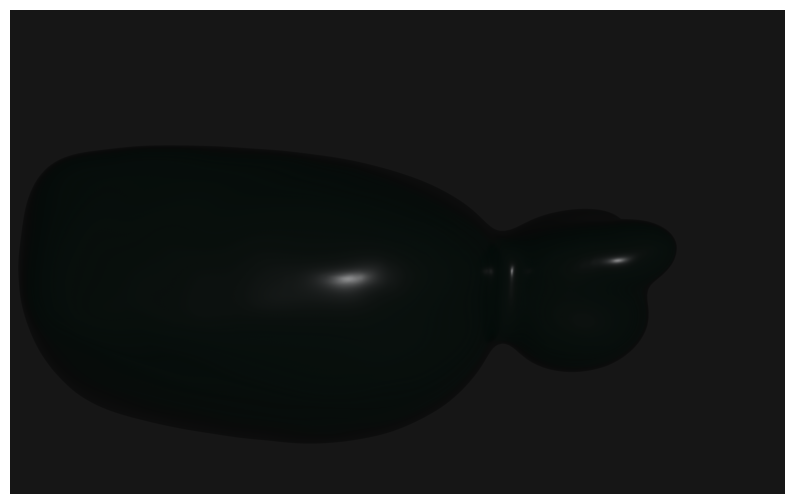

In [53]:
import matplotlib.pyplot as plt

light_positions = [
    [481.0, -383.0, 527.0],  # Top left bottom
    [481.0, -338.0, 885.0],  # Top left up
    [-552.0, -300.0, 480.0],  # Top right bottom
    [-532.0, -300.0, 890.0],  # Top right up
    [475.0, 198.0, 460.0],  # Left mid bottom
    [283.0, 168.0, 1010.0],  # Top left mid
    [-365.0, 103.0, 1010.0],  # Top right mid
    [-518.0, 162.0, 460.0]  # Right mid bottom
]
x_axis = [1,0,0]
y_axis = [0,1,0]
bsdf_names = sorted(os.listdir(config['bsdf_path']))
bsdf_filename = os.path.join(config['bsdf_path'], bsdf_names[random.randint(0, len(bsdf_names)-1)])
# bsdf_filename = '/data2/datasets/ruoguli/idl_project_datas/bsdf/chm_mint_rgb.bsdf'
bsdf = mi.load_dict({
        'type': 'measured',
        'filename' : bsdf_filename # Use a random bsdf 
         })
print(bsdf_filename)
# image, geo_normal, sh_normal, depth = render("03.obj", T.translate([130.11677, -150.48886, 0.0]).rotate(x_axis, 308).scale(20), light_positions[3])

image, normal = render(os.path.join(config['obj_path'], f"blob10.obj"), T().translate([0.,0.,0.]).rotate(x_axis, 30).rotate(y_axis,0).scale(config['obj_scales'][9]), random_light_position(1200.), camera = camera_40339971, bsdf = bsdf, gen_gt = True)
# mi.util.write_bitmap("spp=1024,int=orthogonal_img.png", image)
plt.figure(figsize=(10, 8))
plt.axis("off")
plt.imshow(image ** (1.0 / 2.2)) # approximate sRGB tonemapping
# plt.imshow(image ** (1.0 / 2.2)) # approximate sRGB tonemapping

In [54]:
mi.util.write_bitmap('test.png', image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98564583..0.99997556].


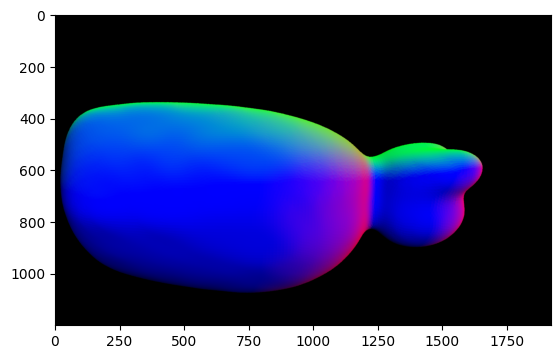

In [44]:
plt.imshow(normal) # approximate sRGB tonemapping

In [55]:
mi.util.write_bitmap('normal.exr', normal)

In [15]:
blobby_dataset_generation()

blob01.obj
blob01.obj
blob01.obj
blob01.obj
blob01.obj
blob01.obj
blob01.obj
blob01.obj
blob01.obj


RuntimeError: drjit.custom(<mitsuba.python.util._RenderOp>): error while performing a custom differentiable operation. (see above).

In [ ]:
import matplotlib.pyplot as plt
x_axis = [1,0,0]
y_axis = [0,1,0]
image, geo_normal, sh_normal, depth = render('03.obj', T().rotate(x_axis, 308).rotate(y_axis, 0).scale(10), [481.0, -338.0, 885.0])
image_np = np.array(image)

# print(image_np)
plt.figure(figsize=(10, 8))
plt.axis("off")
plt.imshow(image ** (1.0 / 2.2)) # approximate sRGB tonemapping

In [26]:
i

AttributeError: 'tuple' object has no attribute 'shape'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


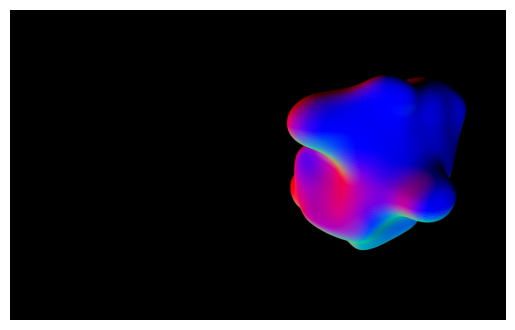

In [38]:
plt.axis("off")
# plt.imshow( image) # approximate sRGB tonemapping
plt.imshow(geo_normal) # approximate sRGB tonemapping

In [119]:
params = mi.traverse(scene)
print(params['obj.vertex_positions'])

[-197.24534606933594, -139.8852996826172, -751.7319946289062, -193.05474853515625, -142.59996032714844, .. 281108 skipped .., 169.14599609375, 635.8270263671875, 135.43260192871094, 178.7447967529297, 634.89404296875]


In [118]:
sensor_params = mi.traverse(sensor)
sensor_params['principal_point_offset_x']

[0.03056168183684349]

In [150]:
light = load_light([0,0,1])
light_params = mi.traverse(light)
light_params['to_world']

[[[-24.5, 0, 0, 0],
  [0, 24.5, 0, 0],
  [0, 0, -24.5, 1],
  [0, 0, 0, 1]]]

In [31]:
rvec =  np.array( [-0.01959622, 2.98679198, 0.63568044])
tvec = np.array([  30.99377083, -12.33525547, 1042.78537089])
cam_pos = [123.19849787, -410.99361859, 951.01024059]
angle = np.linalg.norm(rvec) * 180 / math.pi 
axis = rvec / np.linalg.norm(rvec)
T().translate(cam_pos).rotate(axis = axis, angle = angle)
transf = T().look_at(origin = cam_pos, target = [0,0,0], up = [0.30005366, -0.8695189 ,  0.39227328])
transf
# transf.matrix

[[0.941818, 0.314698, -0.118083, 123.199],
 [0.33534, -0.855784, 0.393929, -410.994],
 [0.0229148, -0.410608, -0.911524, 951.01],
 [0, 0, 0, 1]]

In [ ]:
import os
import numpy as np
import mitsuba as mi

def create_directory_structure(base_path):
    paths = ['depth', 'geo_normal', 'shading_normal']
    for path in paths:
        os.makedirs(os.path.join(base_path, path), exist_ok=True)

def npy_to_exr(npy_file, exr_file):
    array = np.load(npy_file)
    mi.util.write_bitmap(exr_file, array)

def convert_npy_to_exr(source_dir, target_dir):
    create_directory_structure(target_dir)
    
    categories = ['depth', 'geo_normal', 'shading_normal']
    
    for category in categories:
        source_path = os.path.join(source_dir, category)
        target_path = os.path.join(target_dir, category)
        
        for npy_file in os.listdir(source_path):
            if npy_file.endswith('.npy'):
                source_file = os.path.join(source_path, npy_file)
                target_file = os.path.join(target_path, os.path.splitext(npy_file)[0] + '.exr')
                npy_to_exr(source_file, target_file)
                # print(f"Converted {source_file} to {target_file}")

if __name__ == "__main__":
    source_directory = 'generated_data/GT'
    target_directory = 'generated_data/GT_exr'
    
    convert_npy_to_exr(source_directory, target_directory)

##### 